In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

### 데이터 불러오기

In [2]:
df = pd.read_excel('onion_after2013_combined.xlsx')
df.head()

,date_time,상품중품평균가격,자동차용경유,평균기온(℃),최고기온(℃),최저기온(℃),일교차,강수량(mm),1시간최다강수량(mm),평균습도(%rh),...,평균풍속(m/s),일조율(%),year,재배면적합계(ha),10a당생산량(kg),연단위생산량(톤),소비자물가지수,신선야채지수,생활물가지수,식품생활지수
0,2013-01-01,19350.0,1754.81,0.766667,5.366667,-3.766667,9.133333,0.0,0.0,66.366667,...,2.833333,64.100000,2013,20036.0,6458,1294009,-7.272,-4.054000,-5.690000,-13.173000
1,2013-01-02,19350.0,1754.43,-1.400000,2.666667,-6.266667,8.933333,0.0,0.0,46.533333,...,4.800000,89.166667,2013,20036.0,6458,1294009,-7.262,-4.005129,-5.675806,-13.159290
2,2013-01-03,19350.0,1754.02,-5.766667,-2.000000,-8.166667,6.166667,0.0,0.0,37.533333,...,5.466667,76.400000,2013,20036.0,6458,1294009,-7.252,-3.956258,-5.661613,-13.145581
3,2013-01-04,19350.0,1753.94,-3.633333,1.766667,-8.633333,10.400000,0.0,0.0,40.300000,...,2.600000,91.200000,2013,20036.0,6458,1294009,-7.242,-3.907387,-5.647419,-13.131871
4,2013-01-05,19450.0,1753.65,-1.600000,3.933333,-6.333333,10.266667,0.0,0.0,44.833333,...,3.433333,87.833333,2013,20036.0,6458,1294009,-7.232,-3.858516,-5.633226,-13.118161


### df에 year, month 컬럼 추가

In [3]:
df['year'] = pd.DatetimeIndex(df['date_time']).year
df['month'] = pd.DatetimeIndex(df['date_time']).month

# 양파 키우는 기간 동안의 기상 & 토양 환경, 농기계에 쓰인 경유 가격

In [4]:
for i in [5, 11, 23, 35, 47, 59, 71, 83, 95, 107]:
    for col_name in ['자동차용경유', '평균습도(%rh)','강수량(mm)', '일조합(hr)', '평균기온(℃)', 
                     '일조율(%)', '평균풍속(m/s)', '일교차']:   
        ##### 각 행에 1,2,3,4,5,6개월 전의 평균 값 추가하기
        # 새로운 df에 각 월의 평균 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 평균값을 나타내도록
        monthly_mean = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].mean()
        monthly_mean = monthly_mean.shift(periods=i+2, freq='M').reset_index()

        # 새로운 df에 year, month 컬럼 추가
        monthly_mean['year'] = pd.DatetimeIndex(monthly_mean['date_time']).year
        monthly_mean['month'] = pd.DatetimeIndex(monthly_mean['date_time']).month

        # 새로 생긴 컬럼 이름을 바꿔줌
        monthly_mean = monthly_mean.rename(columns={str(col_name): str(i+1)+'개월전'+str(col_name)})

        # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
        df = pd.merge(df, monthly_mean, on=['year', 'month'], how='left')

        # 겹치는 date_time 제거
        df = df.rename(columns={'date_time_x': 'date_time'})
        df = df.drop('date_time_y', axis=1)


#  6개월, N년 전 가격&물가지수 -> 가장 최근 가격 & 같은 시기의 가격 반영

In [5]:
for i in [7,13, 25, 37, 49, 61, 73, 85, 97, 109]:
    for col_name in ['상품중품평균가격','소비자물가지수', '신선야채지수', '생활물가지수', '식품생활지수']:   
        ##### 각 행에 1개월, N년 전의 평균 값 추가하기
        # 새로운 df에 각 월의 평균 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 평균값을 나타내도록
        monthly_yearly_mean = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].mean()
        monthly_yearly_mean = monthly_yearly_mean.shift(periods=i, freq='M').reset_index()

        # 새로운 df에 year, month 컬럼 추가
        monthly_yearly_mean['year'] = pd.DatetimeIndex(monthly_yearly_mean['date_time']).year
        monthly_yearly_mean['month'] = pd.DatetimeIndex(monthly_yearly_mean['date_time']).month

        # 새로 생긴 컬럼 이름을 바꿔줌
        monthly_yearly_mean = monthly_yearly_mean.rename(columns={str(col_name): str(i-1)+'개월전'+str(col_name)})

        # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
        df = pd.merge(df, monthly_yearly_mean, on=['year', 'month'], how='left')

        # 겹치는 date_time 제거
        df = df.rename(columns={'date_time_x': 'date_time'})
        df = df.drop('date_time_y', axis=1)


# 작년의 재배면적 & 면적당 생산량 & 총생산량 -> 다음 재배 계획에 영향

In [6]:
for col_name in ['재배면적합계(ha)', '10a당생산량(kg)', '연단위생산량(톤)']:   
    ##### 각 행에 1개월, N년 전의 평균 값 추가하기
    # 새로운 df에 각 월의 평균 값을 구한 후, 값을 한 달씩 뒤로 미룸 -> 전월의 평균값을 나타내도록
    last_year_mean = df.groupby(pd.Grouper(key='date_time', freq='MS'))[str(col_name)].mean()
    last_year_mean = last_year_mean.shift(periods=13, freq='M').reset_index()

    # 새로운 df에 year 컬럼 추가
    last_year_mean['year'] = pd.DatetimeIndex(last_year_mean['date_time']).year
    last_year_mean['month'] = pd.DatetimeIndex(last_year_mean['date_time']).month

    # 새로 생긴 컬럼 이름을 바꿔줌
    last_year_mean = last_year_mean.rename(columns={str(col_name): '1년전'+str(col_name)})

    # 새로 만든 컬럼을 연도 및 월을 기준으로 원래 데이터 프레임과 병합
    df = pd.merge(df, last_year_mean, on=['year', 'month'], how='left')

    # 겹치는 date_time 제거
    df = df.rename(columns={'date_time_x': 'date_time'})
    df = df.drop('date_time_y', axis=1)

In [7]:
df.isnull().sum()

date_time            0
상품중품평균가격             0
자동차용경유               0
평균기온(℃)              0
최고기온(℃)              0
                  ... 
108개월전생활물가지수      3287
108개월전식품생활지수      3287
1년전재배면적합계(ha)      365
1년전10a당생산량(kg)     365
1년전연단위생산량(톤)       365
Length: 162, dtype: int64

In [8]:
new_df=df.copy()
new_df = new_df.set_index('date_time')
new_df.head()

,상품중품평균가격,자동차용경유,평균기온(℃),최고기온(℃),최저기온(℃),일교차,강수량(mm),1시간최다강수량(mm),평균습도(%rh),최저습도(%rh),...,96개월전생활물가지수,96개월전식품생활지수,108개월전상품중품평균가격,108개월전소비자물가지수,108개월전신선야채지수,108개월전생활물가지수,108개월전식품생활지수,1년전재배면적합계(ha),1년전10a당생산량(kg),1년전연단위생산량(톤)
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,19350.0,1754.81,0.766667,5.366667,-3.766667,9.133333,0.0,0.0,66.366667,52.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,19350.0,1754.43,-1.400000,2.666667,-6.266667,8.933333,0.0,0.0,46.533333,31.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,19350.0,1754.02,-5.766667,-2.000000,-8.166667,6.166667,0.0,0.0,37.533333,27.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,19350.0,1753.94,-3.633333,1.766667,-8.633333,10.400000,0.0,0.0,40.300000,23.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,19450.0,1753.65,-1.600000,3.933333,-6.333333,10.266667,0.0,0.0,44.833333,21.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Train Test Split

In [9]:
from sklearn.model_selection import TimeSeriesSplit

# test data가 6개월씩 되도록 3번 반복
tss = TimeSeriesSplit(n_splits=3, test_size=30*6, gap=0)
new_df = new_df.sort_index()

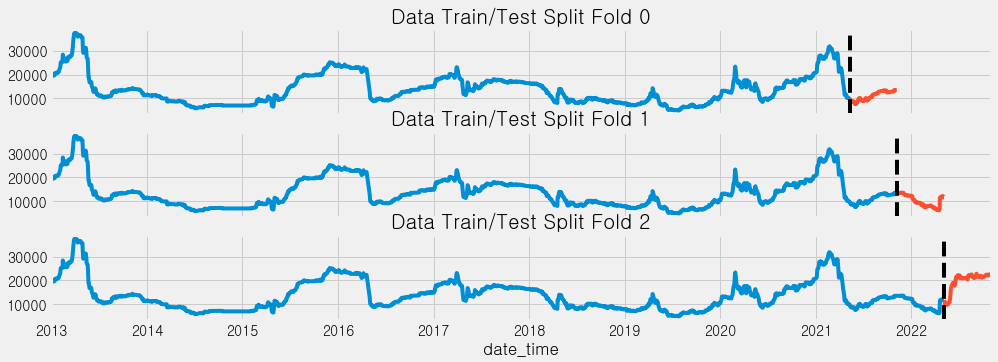

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(new_df):
    train = new_df.iloc[train_idx]
    test = new_df.iloc[val_idx]
    train['상품중품평균가격'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['상품중품평균가격'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [11]:
new_df.head(3)

,상품중품평균가격,자동차용경유,평균기온(℃),최고기온(℃),최저기온(℃),일교차,강수량(mm),1시간최다강수량(mm),평균습도(%rh),최저습도(%rh),...,96개월전생활물가지수,96개월전식품생활지수,108개월전상품중품평균가격,108개월전소비자물가지수,108개월전신선야채지수,108개월전생활물가지수,108개월전식품생활지수,1년전재배면적합계(ha),1년전10a당생산량(kg),1년전연단위생산량(톤)
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,19350.0,1754.81,0.766667,5.366667,-3.766667,9.133333,0.0,0.0,66.366667,52.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,19350.0,1754.43,-1.400000,2.666667,-6.266667,8.933333,0.0,0.0,46.533333,31.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,19350.0,1754.02,-5.766667,-2.000000,-8.166667,6.166667,0.0,0.0,37.533333,27.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 날짜 정보 추가 (요일, 월, 연도, 분기 등)

In [12]:
new_df = new_df.reset_index()
new_df['date_time'] = pd.to_datetime(new_df['date_time'])
new_df = new_df.set_index('date_time')

# 달, 주, 일 정보 추가
def create_features(new_df):
    """
    Create time series features based on time series index.
    """
    new_df = new_df.copy()
    new_df['dayofweek'] = new_df.index.dayofweek
    new_df['quarter'] = new_df.index.quarter
    new_df['month'] = new_df.index.month
    new_df['year'] = new_df.index.year
    new_df['dayofyear'] = new_df.index.dayofyear
    new_df['dayofmonth'] = new_df.index.day
    return new_df

new_df = create_features(new_df)

new_df.head(3)

,상품중품평균가격,자동차용경유,평균기온(℃),최고기온(℃),최저기온(℃),일교차,강수량(mm),1시간최다강수량(mm),평균습도(%rh),최저습도(%rh),...,108개월전신선야채지수,108개월전생활물가지수,108개월전식품생활지수,1년전재배면적합계(ha),1년전10a당생산량(kg),1년전연단위생산량(톤),dayofweek,quarter,dayofyear,dayofmonth
date_time,,,,,,,,,,,,,,,,,,,,,
2013-01-01,19350.0,1754.81,0.766667,5.366667,-3.766667,9.133333,0.0,0.0,66.366667,52.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1
2013-01-02,19350.0,1754.43,-1.400000,2.666667,-6.266667,8.933333,0.0,0.0,46.533333,31.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2,2
2013-01-03,19350.0,1754.02,-5.766667,-2.000000,-8.166667,6.166667,0.0,0.0,37.533333,27.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3,3


# 모든변수 넣은 6개월 후 예측모델

[0]	validation_0-rmse:15091.96206	validation_1-rmse:11131.49590
[100]	validation_0-rmse:6091.32716	validation_1-rmse:3502.43598
[200]	validation_0-rmse:2951.62032	validation_1-rmse:1543.84026
[238]	validation_0-rmse:2439.10665	validation_1-rmse:1560.03015


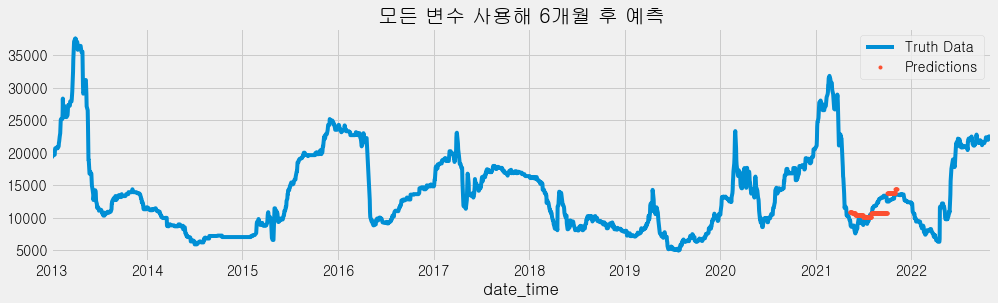

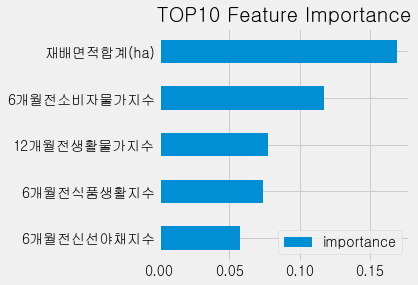

[0]	validation_0-rmse:14900.88797	validation_1-rmse:10314.38888
[100]	validation_0-rmse:6053.37709	validation_1-rmse:2318.36136
[176]	validation_0-rmse:3405.73216	validation_1-rmse:2475.99914


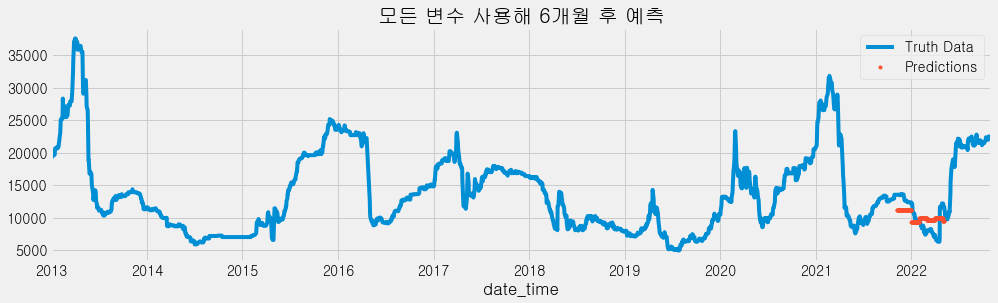

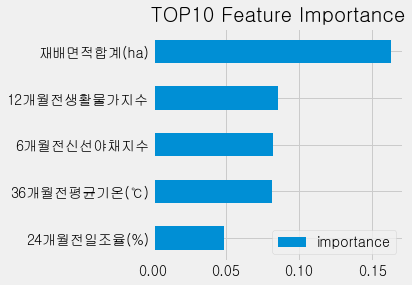

[0]	validation_0-rmse:14696.45245	validation_1-rmse:19944.73458
[100]	validation_0-rmse:5961.06439	validation_1-rmse:13119.14720
[200]	validation_0-rmse:2876.20959	validation_1-rmse:10764.42748
[300]	validation_0-rmse:1875.82168	validation_1-rmse:9759.87087
[400]	validation_0-rmse:1553.88401	validation_1-rmse:9445.90138
[500]	validation_0-rmse:1372.30875	validation_1-rmse:9236.25788
[600]	validation_0-rmse:1251.57952	validation_1-rmse:9125.09559
[700]	validation_0-rmse:1189.73950	validation_1-rmse:9067.26171
[800]	validation_0-rmse:1139.81770	validation_1-rmse:8978.55208
[900]	validation_0-rmse:1088.89579	validation_1-rmse:8862.28737
[1000]	validation_0-rmse:1043.41844	validation_1-rmse:8786.40129
[1100]	validation_0-rmse:1005.32539	validation_1-rmse:8716.47084
[1200]	validation_0-rmse:965.96682	validation_1-rmse:8680.21100
[1294]	validation_0-rmse:935.18445	validation_1-rmse:8671.20520


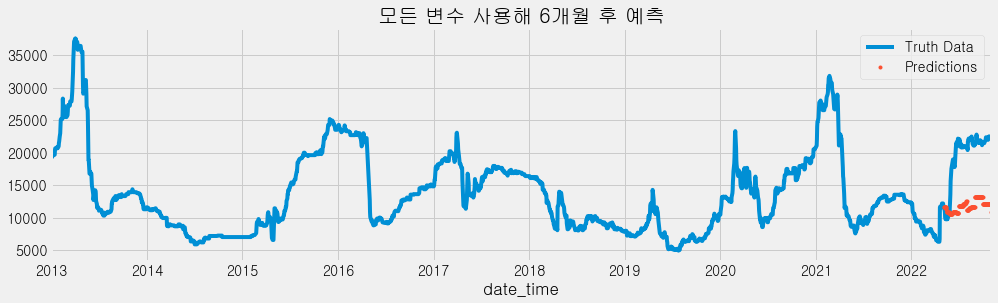

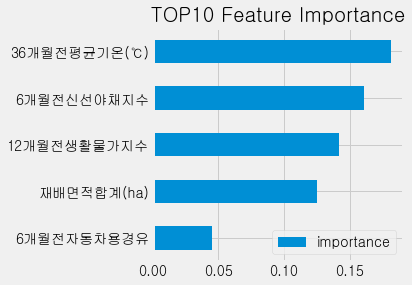

In [13]:
tss = TimeSeriesSplit(n_splits=3, test_size=30*6, gap=0)
new_df = new_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(new_df):
    new_df2 = new_df.copy()
    train = new_df.iloc[train_idx]
    test = new_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)


    FEATURES = [
        '6개월전상품중품평균가격',
        '12개월전상품중품평균가격', '24개월전상품중품평균가격', '36개월전상품중품평균가격',
        '48개월전상품중품평균가격', '60개월전상품중품평균가격', '72개월전상품중품평균가격',
        '84개월전상품중품평균가격', '96개월전상품중품평균가격', '108개월전상품중품평균가격',
        'month', 'dayofweek', 'quarter', 'dayofyear',
        '6개월전자동차용경유',
        '12개월전평균습도(%rh)','12개월전강수량(mm)', '12개월전일조합(hr)', 
        '12개월전일조율(%)','12개월전평균기온(℃)', '12개월전일교차', '12개월전평균풍속(m/s)',
        '24개월전자동차용경유', '24개월전평균습도(%rh)','24개월전강수량(mm)', '24개월전일조합(hr)', 
        '24개월전일조율(%)','24개월전평균기온(℃)', '24개월전일교차', '24개월전평균풍속(m/s)', 
        '36개월전자동차용경유', '36개월전평균습도(%rh)','36개월전강수량(mm)', '36개월전일조합(hr)', 
        '36개월전일조율(%)','36개월전평균기온(℃)', '36개월전일교차', '36개월전평균풍속(m/s)', 
        '48개월전자동차용경유', '48개월전평균습도(%rh)','48개월전강수량(mm)', '48개월전일조합(hr)', 
        '48개월전일조율(%)','48개월전평균기온(℃)', '48개월전일교차', '48개월전평균풍속(m/s)', 
        '60개월전자동차용경유', '60개월전평균습도(%rh)','60개월전강수량(mm)', '60개월전일조합(hr)', 
        '60개월전일조율(%)','60개월전평균기온(℃)', '60개월전일교차', '60개월전평균풍속(m/s)', 
        '72개월전자동차용경유', '72개월전평균습도(%rh)','72개월전강수량(mm)', '72개월전일조합(hr)', 
        '72개월전일조율(%)','72개월전평균기온(℃)', '72개월전일교차', '72개월전평균풍속(m/s)', 
        '84개월전자동차용경유', '84개월전평균습도(%rh)','84개월전강수량(mm)', '84개월전일조합(hr)', 
        '84개월전일조율(%)','84개월전평균기온(℃)', '84개월전일교차', '84개월전평균풍속(m/s)', 
        '96개월전자동차용경유', '96개월전평균습도(%rh)','96개월전강수량(mm)', '96개월전일조합(hr)', 
        '96개월전일조율(%)','96개월전평균기온(℃)', '96개월전일교차', '96개월전평균풍속(m/s)', 
        '108개월전자동차용경유', '108개월전평균습도(%rh)','108개월전강수량(mm)', '108개월전일조합(hr)', 
        '108개월전일조율(%)','108개월전평균기온(℃)', '108개월전일교차', '108개월전평균풍속(m/s)', 
        '재배면적합계(ha)','1년전10a당생산량(kg)', '1년전재배면적합계(ha)', '1년전연단위생산량(톤)',
        '6개월전소비자물가지수', '6개월전신선야채지수', '6개월전생활물가지수', '6개월전식품생활지수',
        '12개월전소비자물가지수', '12개월전신선야채지수', '12개월전생활물가지수', '12개월전식품생활지수',
        '24개월전소비자물가지수', '24개월전신선야채지수', '24개월전생활물가지수', '24개월전식품생활지수',
        '36개월전소비자물가지수', '36개월전신선야채지수', '36개월전생활물가지수', '36개월전식품생활지수',
        '48개월전소비자물가지수', '48개월전신선야채지수', '48개월전생활물가지수', '48개월전식품생활지수',
        '60개월전소비자물가지수', '60개월전신선야채지수', '60개월전생활물가지수', '60개월전식품생활지수',
        '72개월전소비자물가지수', '72개월전신선야채지수', '72개월전생활물가지수', '72개월전식품생활지수',
        '84개월전소비자물가지수', '84개월전신선야채지수', '84개월전생활물가지수', '84개월전식품생활지수',
        '96개월전소비자물가지수', '96개월전신선야채지수', '96개월전생활물가지수', '96개월전식품생활지수',
        '108개월전소비자물가지수', '108개월전신선야채지수', '108개월전생활물가지수', '108개월전식품생활지수'
            ]
    
    TARGET = '상품중품평균가격'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    test['prediction'] = reg.predict(X_test)
    new_df2 = new_df2.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = new_df2[['상품중품평균가격']].plot(figsize=(15, 4))
    new_df2['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('모든 변수 사용해 6개월 후 예측')
    plt.show()
    
    # Feature Importance plot
    fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                 columns=['importance'])

    fi.sort_values('importance').tail(5).plot(kind='barh', title='TOP10 Feature Importance',figsize=(4,4))
    plt.show()

# 변수 선택한 6개월 후 예측모델

[0]	validation_0-rmse:15092.26684	validation_1-rmse:11144.51065
[100]	validation_0-rmse:6090.42495	validation_1-rmse:2599.66585
[200]	validation_0-rmse:2977.43744	validation_1-rmse:1130.04052
[224]	validation_0-rmse:2632.88535	validation_1-rmse:1203.85814


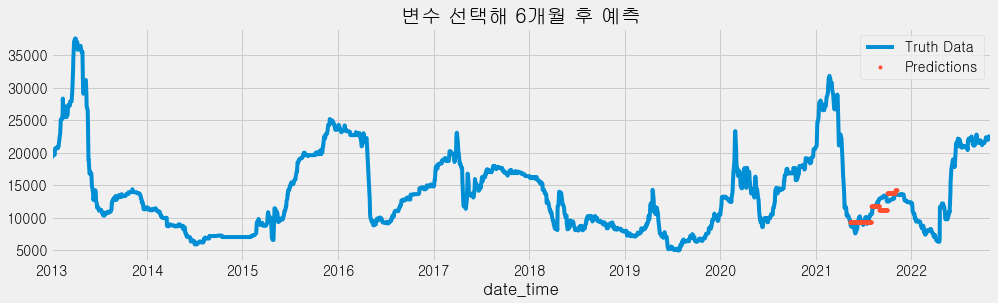

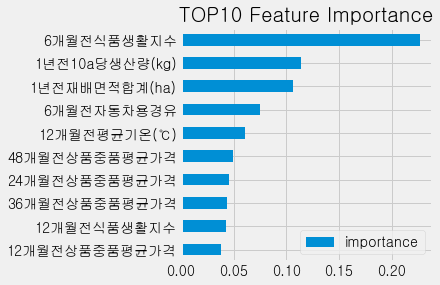

[0]	validation_0-rmse:14901.40487	validation_1-rmse:10311.20455
[100]	validation_0-rmse:6068.58552	validation_1-rmse:2433.75219
[200]	validation_0-rmse:2939.44101	validation_1-rmse:1861.18166
[203]	validation_0-rmse:2891.73255	validation_1-rmse:1878.82246


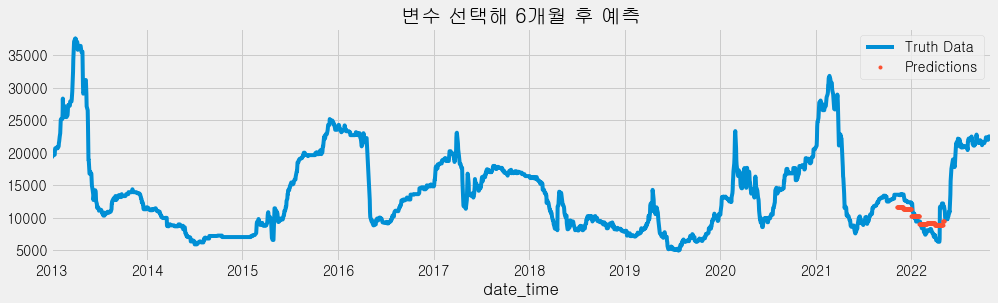

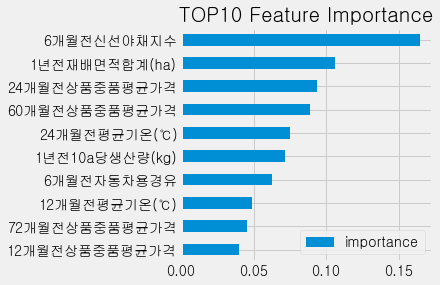

[0]	validation_0-rmse:14696.78654	validation_1-rmse:19995.82835
[100]	validation_0-rmse:6012.30593	validation_1-rmse:13253.94657
[200]	validation_0-rmse:2909.93046	validation_1-rmse:10442.90949
[300]	validation_0-rmse:1956.67268	validation_1-rmse:9293.88814
[400]	validation_0-rmse:1659.25538	validation_1-rmse:8970.31419
[500]	validation_0-rmse:1568.17671	validation_1-rmse:8740.43545
[600]	validation_0-rmse:1511.74710	validation_1-rmse:8520.66588
[700]	validation_0-rmse:1463.23145	validation_1-rmse:8430.90696
[800]	validation_0-rmse:1431.33331	validation_1-rmse:8416.37348
[818]	validation_0-rmse:1426.73622	validation_1-rmse:8416.13942


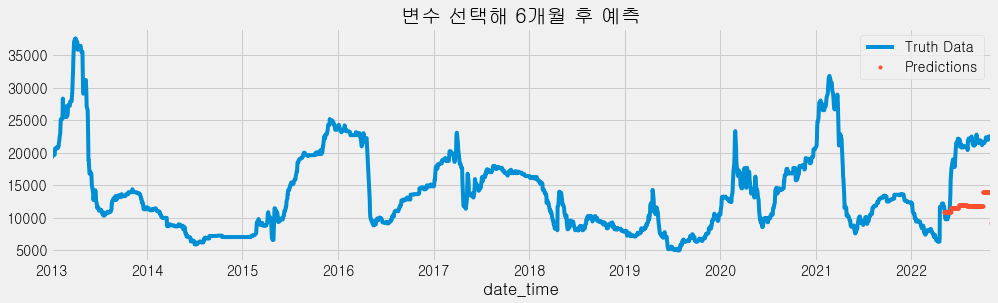

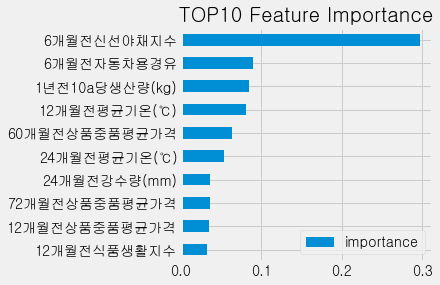

In [14]:
tss = TimeSeriesSplit(n_splits=3, test_size=30*6, gap=0)
new_df = new_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(new_df):
    new_df2 = new_df.copy()
    train = new_df.iloc[train_idx]
    test = new_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)


    FEATURES = [
        '6개월전상품중품평균가격',
        '12개월전상품중품평균가격', '24개월전상품중품평균가격', '36개월전상품중품평균가격',
        '48개월전상품중품평균가격', '60개월전상품중품평균가격', '72개월전상품중품평균가격',
        '84개월전상품중품평균가격', '96개월전상품중품평균가격', '108개월전상품중품평균가격',
        'month', 'quarter', 
        '6개월전자동차용경유', 
        '12개월전평균습도(%rh)','12개월전강수량(mm)',
        '12개월전평균기온(℃)', 
        '24개월전평균습도(%rh)','24개월전강수량(mm)',
        '24개월전평균기온(℃)', 
        '1년전10a당생산량(kg)', '1년전재배면적합계(ha)',
        '6개월전신선야채지수', '6개월전식품생활지수',
        '12개월전신선야채지수', 
        '12개월전식품생활지수'
            ]
    
    TARGET = '상품중품평균가격'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)


    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    test['prediction'] = reg.predict(X_test)
    new_df2 = new_df2.merge(test[['prediction']], how='left', left_index=True, right_index=True)
    ax = new_df2[['상품중품평균가격']].plot(figsize=(15, 4))
    new_df2['prediction'].plot(ax=ax, style='.')
    plt.legend(['Truth Data', 'Predictions'])
    ax.set_title('변수 선택해 6개월 후 예측')
    plt.show()
    
    # Feature Importance plot
    fi = pd.DataFrame(data=reg.feature_importances_,
                 index=reg.feature_names_in_,
                 columns=['importance'])

    fi.sort_values('importance').tail(10).plot(kind='barh', title='TOP10 Feature Importance',figsize=(4,4))
    plt.show()